2.0 / Toyota Mirai
Iter: 0 ,R_tot: 104425.46 ,R_greedy: 104425.46 ,soc: 0.79 ,mean(Q) 0.0
Worse: 1 ,R_tot: 104425.46 ,R_greedy: 104425.46 ,soc: 0.79 ,mean(Q) 0.0
Iter: 1 ,R_tot: 105889.29 ,R_greedy: 104425.46 ,soc: 0.79 ,mean(Q) 0.0
Better: 2 ,R_tot: 105889.29 ,R_greedy: 105889.29 ,soc: 0.79 ,mean(Q) 0.4
Iter: 2 ,R_tot: 105929.4 ,R_greedy: 105889.29 ,soc: 0.79 ,mean(Q) 0.4
Better: 3 ,R_tot: 105929.4 ,R_greedy: 105929.4 ,soc: 0.79 ,mean(Q) 0.9
Iter: 3 ,R_tot: 105895.71 ,R_greedy: 105929.4 ,soc: 0.79 ,mean(Q) 0.9
Worse: 4 ,R_tot: 105895.71 ,R_greedy: 105929.4 ,soc: 0.79 ,mean(Q) 0.9
Iter: 4 ,R_tot: 108769.9 ,R_greedy: 105929.4 ,soc: 0.79 ,mean(Q) 0.9
MPG is:  110.69938385866615


<IPython.core.display.Javascript object>


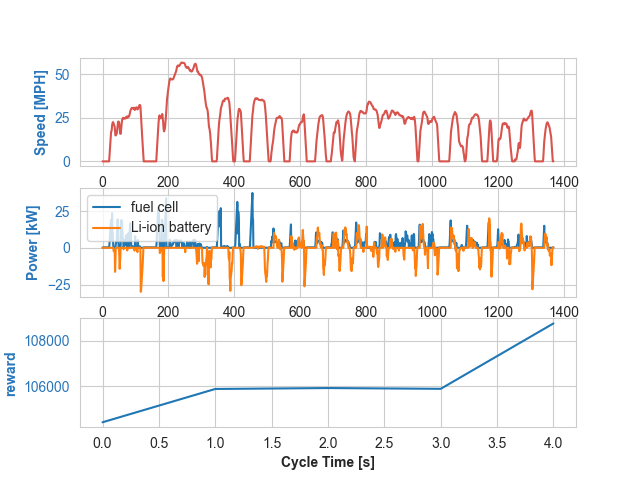

In [3]:
#### RL
import sys
sys.path.append('../src')
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
import BX_lib
sns.set_style('whitegrid')

%matplotlib notebook

import FASTSim_BX

##################################################################################
# Individual Drive Cycle
# Load Drive Cycle
# Default (UDDS, US06, HWFET) cycles can be loaded from the ../cycles directory, or custom cycles can be specified in the same format. The expected format is a dictionary with the following keys:
# ['cycGrade', 'cycMps', 'cycSecs', 'cycRoadType']
#     cycGrade = Road grade [%/100]
#     cycMps = Vehicle speed [meters per second]
#     cycSecs = Relative time in the cycles [seconds]
#     cycRoadType = Indicator as to whether or not there is a wireless charging capability from the road to vehicle
# There is no limit to the length of a drive cycle that can be provided as an input to FASTSim.
cyc = FASTSim_BX.get_standard_cycle("UDDS")


##################################################################################
# choose Powertrain Model ########################################################
##################################################################################
# A vehicle database in CSV format is required to be in the working directory where FASTSim is running 
# (i.e. the same directory as this notebook). The "get_veh" function selects the appropriate vehicle
# attributes from the database and contructs the powertrain model (engine efficiency map, etc.). 
# An integer value corresponds to each vehicle in the database. To add a new vehicle, simply 
# populate a new row to the vehicle database CSV.

### Toyota Mirai fuel cell
veh_num=24

### Hyndai Tucson fuel cell
# veh_num=23

veh = FASTSim_BX.get_veh(veh_num)
print(veh['vehPtType'],'/',veh['name'])


########################################################################################
# choose baseline EMS strategy #########################################################
########################################################################################
veh['EMS']='RL'
# veh['EMS']='ECMS'
# veh['EMS']='rule'

########################################################################################
# RL parameter setup

### min/max s and a
s_num=2
s1_min=-30;s1_max=30  # P_dmd [Kw]
s2_min=0;  s2_max=30   # v [mps]
s3_min=0.4;  s3_max=0.9   # soc
a_min=0;  a_max=1    # P split ratio
reso_s=5;reso_a=11
ss=np.zeros([s_num,reso_s])
### discretization        
ss[0,]=np.linspace(s1_min,s1_max,reso_s)
ss[1,]=np.linspace(s2_min,s2_max,reso_s)
if s_num==2:
    gap_s=np.array([(s1_max-s1_min)/((reso_s-1)*2), (s2_max-s2_min)/((reso_s-1)*2)])    
else:
    gap_s=np.array([(s1_max-s1_min)/((reso_s-1)*2), (s2_max-s2_min)/((reso_s-1)*2), (s3_max-s3_min)/((reso_s-1)*2)])
    ### discretization    
    ss[2,]=np.linspace(s3_min,s3_max,reso_s)
    
gap_a=(a_max-a_min)/((reso_a-1)*2)
aa=np.linspace(a_min,a_max,reso_a)

### Value definition
Q=np.zeros(reso_a*reso_s**s_num)

tot_m_norm=0.001
soc_error_norm=0.1
cost_bias=100
# w_m=0.03
w_m=0.9
gamma                   =   0.99  # discount factor [-] / range: [0,1]
number_of_random_action =   2  # number of random actions out of 1800 time steps of the cycle
RQ_split                = 0.1  # split ratio between reward and Q value [-] / range: [0,1]
alpha1                  = 0.1  # learning rate [-] / range: [0,1]
rd_range=2
cyc_L=int(cyc['cycSecs'][-1])
secs=cyc['cycSecs']
maxMotorKw=veh['maxMotorKw']
mcKwOutArray = np.linspace(0,1,101) * maxMotorKw
kWhPerGGE = 33.7

kgPerGallon=2.567 # [kg/gal ~ gasoline]
Qhlv= 120.0*1000000 # low heating value of hydrogen
# Qhlv= 43.0*1000000 # low heating value of gasoline
s_EM = 1
soc_h=0.8
soc_l=0.1
reso=11 
veh['ss']=ss
veh['aa']=aa
veh['gap_s']=gap_s
veh['reso_s']=reso_s
veh['reso_a']=reso_a
mpg_max_greedy=0

N=5
R_tot_list=np.zeros(N)
mpg_list=np.zeros(N)
soc_list=np.zeros(N) 
temp_rd_indx=np.linspace(0,number_of_random_action-1,number_of_random_action)
hard_break=0

### episode simulation
for j in range(N):
    Q_old=copy.deepcopy(Q)    
    
    ### value update
    if j>0:
        for i in range(1, cyc_L):    
            ### get value funcitons of current state
            if s_num==2:
                s_now=[s_ele0[i-1],s_ele1[i-1]]
                indx_now_list = BX_lib.indx_list_search_s2(s_now,ss,gap_s,reso_s,reso_a)            
            else:
                s_now=[s_ele0[i-1],s_ele1[i-1],s_ele2[i-1]]
                indx_now_list = BX_lib.indx_list_search_s3(s_now,ss,gap_s,reso_s,reso_a)            
            a_now=a_ele[i-1]
            Q_now_max_indx = BX_lib.indx_search(a_now,aa,gap_a)
            
            ### get value funcitons of next state
            if s_num==2:
                s_next=[s_ele0[i],s_ele1[i]]            
                indx_next_list = BX_lib.indx_list_search_s2(s_next,ss,gap_s,reso_s,reso_a)
            else:
                s_next=[s_ele0[i],s_ele1[i],s_ele2[i]]            
                indx_next_list = BX_lib.indx_list_search_s3(s_next,ss,gap_s,reso_s,reso_a)
            Q_next_list=Q_old[indx_next_list]
            
            ### find the max value of next state
            Q_next_max_indx = np.argmax(Q_next_list)
            Q_next_max = Q_next_list[Q_next_max_indx]

            #### reward calculation                       
            if mcMechKw4ForcedFc[i]==0:
                gam=1
            else:
                gam = (np.sign(mcMechKw4ForcedFc[i])+1)*0.5        
            eff_EM = np.interp(np.abs(mcMechKw4ForcedFc[i]), mcKwOutArray, veh['mcFullEffArray'])            
            m_equ_em_no_penalty =(s_EM*gam/eff_EM + s_EM*(1-gam)*eff_EM)*(mcMechKw4ForcedFc[i]*1000)/Qhlv;
            x_soc = (soc[i-1]-soc_l)/(soc_h-soc_l);
            weight_c=1;
            f_penalty=(1-(x_soc**3)/2)*weight_c; # penalty
            mc_m = f_penalty * m_equ_em_no_penalty            
            # fuel consumption
            fsKwOutAch1 = transKwInAch[i]-mcMechKw4ForcedFc[i]
            fsKwhOutAch1=fsKwOutAch1*secs[i]*(1/3600.0)
            fs_m = fsKwhOutAch1*(1/kWhPerGGE)*kgPerGallon # [kg]
            tot_m = mc_m+fs_m                                   
            R[i]=-w_m*tot_m/tot_m_norm + cost_bias - (1-w_m)*(0.6-soc[i])*(soc[i]<0.6)/soc_error_norm;            
            
            ### value update
            if i>0:
                for jj in range(len(temp_rd_indx)):
                    
                    ###### temp_rd_index == random action index ######
                    if indx_now_list[Q_now_max_indx] == temp_rd_indx[jj]:
                        Q[indx_now_list[Q_now_max_indx]]=(1-alpha1)*Q[indx_now_list[Q_now_max_indx]] \
                        + alpha1*(R[i] + gamma*Q_next_max) 
            else:
                Q[indx_now_list[Q_now_max_indx]]=(1-alpha1)*Q[indx_now_list[Q_now_max_indx]] + \
                alpha1*(R[i] + gamma*Q_next_max)                

        ### check MPG after update and throw the above update if MPG drops after update  
        veh['Q']=Q    
        output = FASTSim_BX.sim_drive(cyc, veh)
        df = pd.DataFrame.from_dict(output)\
            [['soc','transKwInAch','mpsAch','curMaxMechMcKwIn',\
              's_ele0','s_ele1','s_ele2','a_ele','a_indx','s_indx','mpgge','mcMechKw4ForcedFc','essKwOutAch','mcMechKwOutAch']]
        # postprocess
        soc=df['soc']
        a_ele=df['a_ele']
        s_ele0=df['s_ele0']
        s_ele1=df['s_ele1']
        s_ele2=df['s_ele2']
        s_indx=df['s_indx']
        a_indx=df['a_indx']
        transKwInAch=df['transKwInAch']
        mpsAch=df['mpsAch']
        curMaxMechMcKwIn=df['curMaxMechMcKwIn']
        VEH_mpg=df['mpgge']
        mcMechKw4ForcedFc=df['mcMechKw4ForcedFc']

        R=np.zeros(cyc_L)
        for i0 in range(1,cyc_L):
            #### reward calculation using ECMS algorithm                
            if mcMechKw4ForcedFc[i0]==0:
                gam=1
            else:
                gam = (np.sign(mcMechKw4ForcedFc[i0])+1)*0.5        
            eff_EM = np.interp(np.abs(mcMechKw4ForcedFc[i0]), mcKwOutArray, veh['mcFullEffArray'])            
            m_equ_em_no_penalty =(s_EM*gamma/eff_EM + s_EM*(1-gamma)/eff_EM)*(mcMechKw4ForcedFc[i0]*1000)/Qhlv
            x_soc = (soc[i0-1]-soc_l)/(soc_h-soc_l)
            weight_c=1;
            f_penalty=(1-(x_soc**3)/2)*weight_c; # penalty
            mc_m = f_penalty * m_equ_em_no_penalty            
            # engine fuel consumption
            fsKwOutAch1 = transKwInAch[i0]-mcMechKw4ForcedFc[i0]
            fsKwhOutAch1=fsKwOutAch1*secs[i0]*(1/3600.0)
            fs_m = fsKwhOutAch1*(1/kWhPerGGE)*kgPerGallon # [kg]
            tot_m = mc_m+fs_m
            R[i0]=-w_m*tot_m/tot_m_norm+cost_bias - (1-w_m)*(0.6-soc[i0])*(soc[i0]<0.6)/soc_error_norm
        R_tot=np.sum(R) 

        ### reward is better than previous recorded reward
        if R_tot>R_tot_greedy:
            R_tot_greedy=R_tot
            mpg_greedy=VEH_mpg[cyc_L]
            print('Better:',j,',R_tot:',round(R_tot,2),',R_greedy:',round(R_tot_greedy,2),\
                  ',soc:',round(float(soc[cyc_L]),2),',mean(Q)',round(np.mean(Q),1))
        ### reward is worse than previous recorded reward, throw the Q update
        else:
            Q=copy.deepcopy(Q_temp)
            print('Worse:',j,',R_tot:',round(R_tot,2),',R_greedy:',round(R_tot_greedy,2),\
                  ',soc:',round(float(soc[cyc_L]),2),',mean(Q)',round(np.mean(Q),1))
    
    # random action selection
    Q_temp = copy.deepcopy(Q)
    if j>0:
        # get the Q list of the selected single random action
        temp = np.random.randint(cyc_L,size=cyc_L)
        rd_indx_list=np.zeros(number_of_random_action)
        cnt1=0
        # rd action #1
        for rq in range(number_of_random_action):
            mk=0
            while mk==0:
                rd_indx = int(s_indx[temp[rq+cnt1]])
                rpt=0
                for ee in range(rq):
                    if rd_indx==rd_indx_list[ee]:
                        rpt=1
                        break                   
                if rpt==0:
                    mk=1;
                else:
                    cnt1=cnt1+1;               
            rd_indx_list[rq]=rd_indx            
            Q_list = Q[rd_indx:rd_indx+reso_a]
            Q_ele=np.argmax(Q_list)
            Q_value=Q_list[Q_ele]
            if Q_value==0:
                Q_ele=0
            # get the random action index and update the Q table
            qw3=np.random.randint(rd_range*2+1,size=rd_range*2+1)
            qw2=int(max(1,min(reso_a,qw3[0]+Q_ele-rd_range)))
            Q[rd_indx+qw2]=Q_value+1
            temp_rd_indx[rq]= rd_indx+qw2
        
    # vehicle simulation with the random action integrated in value function
    veh['Q']=Q
    Q_rd=copy.deepcopy(Q)
    output = FASTSim_BX.sim_drive(cyc, veh)
    df = pd.DataFrame.from_dict(output)\
        [['soc','transKwInAch','mpsAch','curMaxMechMcKwIn',\
          's_ele0','s_ele1','s_ele2','a_ele','a_indx','s_indx','mpgge','mcMechKw4ForcedFc','essKwOutAch','mcMechKwOutAch']]
    Q=copy.deepcopy(Q_temp)
    
    # postprocess
    soc=df['soc']
    a_ele=df['a_ele']
    s_ele0=df['s_ele0']
    s_ele1=df['s_ele1']
    s_ele2=df['s_ele2']
    s_indx=df['s_indx']
    a_indx=df['a_indx']
    transKwInAch=df['transKwInAch']
    mpsAch=df['mpsAch']
    curMaxMechMcKwIn=df['curMaxMechMcKwIn']
    VEH_mpg=df['mpgge']
    mcMechKw4ForcedFc=df['mcMechKw4ForcedFc']
    
    R=np.zeros(cyc_L)
    for i0 in range(1,cyc_L):
        #### reward calculation using ECMS algorithm                
        if mcMechKw4ForcedFc[i0]==0:
            gam=1
        else:
            gam = (np.sign(mcMechKw4ForcedFc[i0])+1)*0.5        
        eff_EM = np.interp(np.abs(mcMechKw4ForcedFc[i0]), mcKwOutArray, veh['mcFullEffArray'])            
        m_equ_em_no_penalty =(s_EM*gamma/eff_EM + s_EM*(1-gamma)/eff_EM)*(mcMechKw4ForcedFc[i0]*1000)/Qhlv
        x_soc = (soc[i0-1]-soc_l)/(soc_h-soc_l)
        weight_c=1;
        f_penalty=(1-(x_soc**3)/2)*weight_c; # penalty
        mc_m = f_penalty * m_equ_em_no_penalty            
        # engine fuel consumption
        fsKwOutAch1 = transKwInAch[i0]-mcMechKw4ForcedFc[i0]
        fsKwhOutAch1=fsKwOutAch1*secs[i0]*(1/3600.0)
        fs_m = fsKwhOutAch1*(1/kWhPerGGE)*kgPerGallon # [kg]
        tot_m = mc_m+fs_m
        R[i0]=-w_m*tot_m/tot_m_norm+cost_bias - (1-w_m)*(0.6-soc[i0])*(soc[i0]<0.6)/soc_error_norm
    R_tot=np.sum(R)    
    
    if j==0:
        mpg_greedy=VEH_mpg[cyc_L]        
        R_tot_greedy = R_tot

    R_tot_list[j]=R_tot
    mpg_list[j]=VEH_mpg[cyc_L]
    soc_list[j]=soc[cyc_L]    
    print('Iter:',j,',R_tot:',round(R_tot,2),',R_greedy:',round(R_tot_greedy,2),\
          ',soc:',round(float(soc[cyc_L]),2),',mean(Q)',round(np.mean(Q),1))
    
########################################################################################  
# Results
df = pd.DataFrame.from_dict(output)[['soc','fcKwInAch','fcKwOutAch','essKwOutAch',\
                                     'mcMechKwOutAch','auxInKw','mcElecKwInAch','mpgge',\
                                     'transKwInAch','mcMechKw4ForcedFc','canPowerAllElectrically','fcForcedOn']]
df['speed'] = cyc['cycMps'] * 2.23694  # Convert mps to mph 
print('MPG is: ',df['mpgge'][cyc_L])


########################################################################################
# save key parameters
np.save('Q_temp',Q_temp)
# Q_temp=np.load('Q_temp.npy')

import pickle
with open('veh.pickle', 'wb') as handle:
    pickle.dump(veh, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('veh.pickle', 'rb') as handle:
#     veh = pickle.load(handle)

with open('cyc.pickle', 'wb') as handle:
    pickle.dump(cyc, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('cyc.pickle', 'rb') as handle:
#     cyc = pickle.load(handle)

########################################################################################
#  plot
ax = plt.subplot(3,1,1)
speed_line = df.speed.plot(color='xkcd:pale red', ax=ax, label='Speed')
ax.set_ylabel('Speed [MPH]', weight='bold', color='xkcd:bluish')
ax.tick_params('y', colors='xkcd:bluish')

ax = plt.subplot(3,1,2)
line1 = df.fcKwOutAch.plot(ax=ax, label='kW')
line2 = df.essKwOutAch.plot(ax=ax, label='kW')
ax.set_ylabel('Power [kW]', weight='bold', color='xkcd:bluish')
ax.tick_params('y', colors='xkcd:bluish')
ax.legend(['fuel cell','Li-ion battery'])

ax11 = plt.subplot(3,1,3)
plt.plot(R_tot_list)
ax11.set_ylabel('reward', weight='bold', color='xkcd:bluish')
# speed_line = df.fuelKgAch.plot(color='xkcd:pale red', ax=ax11, label='Speed')
# ax11.set_ylabel('fuel burned [kg]', weight='bold', color='xkcd:bluish')
ax11.set_xlabel('Cycle Time [s]', weight='bold')
ax11.tick_params('y', colors='xkcd:bluish')

In [4]:
output

{'mpgge': 110.69938385866615,
 'battery_kWh_per_mi': -0.041687591891455475,
 'electric_kWh_per_mi': -0.041687591891455475,
 'maxTraceMissMph': 0.5774346905063105,
 'ess2fuelKwh': -0.13693741059156161,
 'initial_soc': 0.6,
 'final_soc': 0.7941561465115407,
 'mpgge_elec': 128.2634483491423,
 'soc': array([0.6       , 0.6       , 0.6       , ..., 0.79415615, 0.79415615,
        0.79415615]),
 'distance_mi': 7.451853664930395,
 'avg_speed_mph': 19.59581679601857,
 'avg_accel_mphps': 1.128676470467741,
 'ZeroToSixtyTime_secs': 0.0,
 'fcKwOutAch': array([0. , 0.3, 0.3, ..., 0. , 0.3, 0.3]),
 'fsKwhOutAch': array([0.        , 0.00046296, 0.00046296, ..., 0.        , 0.00046296,
        0.00046296]),
 'fcKwInAch': array([0.        , 1.66666667, 1.66666667, ..., 0.        , 1.66666667,
        1.66666667]),
 'essKwOutAch': array([0.        , 0.        , 0.        , ..., 0.28300639, 0.        ,
        0.        ]),
 'time': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.367e+03, 1.368e+03,
    

In [5]:
cycSecs

NameError: name 'cycSecs' is not defined